In [1]:
import numpy as np
import cv2 
import re
from PIL import Image
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

ROOT = '/home/user/data/twins_aligned_resized'

In [2]:
from albumentations import Compose, Normalize, CenterCrop
from albumentations.torch import ToTensor

# define crop transform of your choice
size = 512

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_base = Compose([CenterCrop(size, size),                     
                     Normalize(mean, std),
                     ToTensor()])

transform_kp = Compose([CenterCrop(size, size),                     
                     Normalize(mean, std),
                     ],
                       to_tensor=ToTensor(),
                    keypoint_params={'format': 'xy', 'remove_invisible': False})
                   
#                     additional_targets={'image1': 'image',
#                                         'image2':'image',
#                                         'keypoints1': 'keypoints',
#                                        'keypoints':'keypoints'})

In [3]:
# front images for each id
views = pd.read_csv(os.path.join(ROOT, 'df', 'views.csv'), index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv(os.path.join(ROOT, 'df', 'pairs.csv'))

In [4]:
views.head()

,filename,subject_id,label
person_id,,,
90003,"[90003d17.jpg, 90003d18.jpg, 90003d40.jpg, 900...",90003,0
90004,"[90004d17.jpg, 90004d18.jpg, 90004d40.jpg, 900...",90004,1
90005,"[90005d17.jpg, 90005d18.jpg, 90005d40.jpg, 900...",90005,2
90006,"[90006d14.jpg, 90006d15.jpg, 90006d37.jpg, 900...",90006,3
90007,"[90007d17.jpg, 90007d18.jpg, 90007d36.jpg, 900...",90007,4


In [5]:
pairs.head()

,id_1,id_2,label
0,90308,90308,Same
1,90404,90404,Same
2,90062,90062,Same
3,90052,90052,Same
4,90144,90144,Same


### For siamese classification & similarity learning

In [6]:
def imread(path):
    img = cv2.imread(os.path.join(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if min(img.shape[:2])<size:
        ratio = size/min(img.shape[:2])+0.1
        img = cv2.resize(img, (0,0), fx=ratio, fy=ratio)
    return img

def parse_keypoints(kp_raw):
    data = list(kp_raw.apply(eval))
    return np.array(data)
    
class TwinPairsDataset(Dataset):
    def __init__(self, dataroot, df_pairs, df_views, transform=transform_base, keypoints=False, id_columns=['id_1', 'id_2']):
        '''
        dataroot: path to folder with items
        df_pairs: pd dataframe containing pairs of ids and a correspodind label:
                    'Same', 'Fraternal', 'Identical', 'UnknownTwinType',
                    'IdenticalMirror', 'Sibling', 'IdenticalTriplet'
        df_views: pd dataframe containing list of available for each id in the dataset                    
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df_pairs = df_pairs
        self.df_views = df_views
        self.transform = transform
        self.keypoints = keypoints
        self.id_columns = id_columns
        self.n = len(id_columns)
        
    def __getitem__(self, index):
        def get_img_path(person_id, view):
            path = os.path.join(self.dataroot, person_id, view)
            return imread(path)
        
        ids = self.df_pairs.iloc[index][self.id_columns].values
        ids = [str(x) for x in ids]
    
        label = int(self.df_pairs.iloc[index].label=='Same')
        
        if ids[0]==ids[1]:
             views = np.random.choice(self.df_views.loc[ids[0]]['filename'], size=2, replace=False) 
        else:
            views = [np.random.choice(self.df_views.loc[ids[i]]['filename']) for i in range(self.n)]

        paths = [os.path.join(self.dataroot, ids[i], views[i]) for i in range(self.n)]
        
        images = [imread(path) for path in paths]
        
        sample = dict([(f'image{i}',images[i]) for i in range(self.n)])
        
        if self.keypoints:
            kp = [pd.read_csv(os.path.join(self.dataroot, ids[i], 'keypoints.csv')) for i in range(self.n)]
            keypoints = [parse_keypoints(kp[i][views[i]]) for i in range(self.n)]
            
            sample.update(dict([(f'keypoints{i}',keypoints[i]) for i in range(self.n)]))
            
        if self.transform:
            samples = [{'image':image} for image in images]
            
            if self.keypoints:
                for i in range(self.n):
                    samples[i]['keypoints'] = keypoints[i]
                
            augs = [self.transform(**sample) for sample in samples]
            
            sample = dict([(f'image{i}', augs[i]['image']) for i in range(self.n)])

            if self.keypoints:
                sample.update(dict([(f'keypoints{i}',np.array(augs[i]['keypoints'])) for i in range(self.n)]))
        
        sample['label'] = label   
        return sample
    
    def __len__(self):
        return self.df_pairs.shape[0]
    

In [7]:
pairs_dataset = TwinPairsDataset(ROOT, pairs, views, transform=transform_kp, keypoints=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


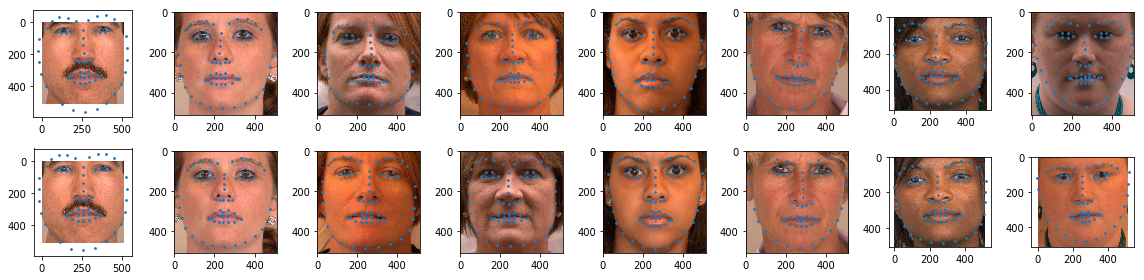

In [8]:
n_show = 8
fig, axs = plt.subplots(2, n_show, figsize=(16, 4))
for idx in range(n_show):
    sample = pairs_dataset[idx]
    
    axs[0, idx].imshow(sample['image1'].numpy().transpose(1,2,0)*std + mean)    
    axs[0, idx].scatter(sample['keypoints1'][:,0], sample['keypoints1'][:,1], s=3)
    
    axs[1, idx].imshow(sample['image0'].numpy().transpose(1,2,0)*std + mean)    
    axs[1, idx].scatter(sample['keypoints0'][:,0], sample['keypoints0'][:,1], s=3)
plt.tight_layout()

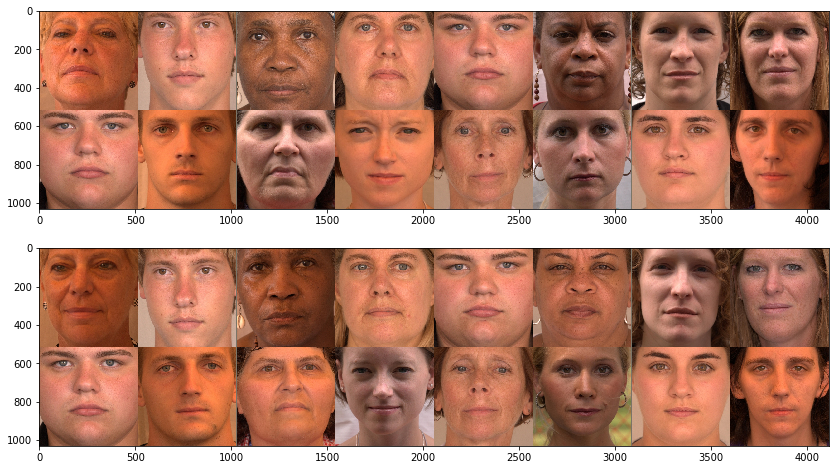

In [9]:
# pairs_dataset = TwinPairsDataset(ROOT, pairs, views, transform=transform_base, keypoints=False)
pairs_dataset = TwinPairsDataset(ROOT, pairs, views, transform=transform_kp, keypoints=True)
pairs_loader = DataLoader(pairs_dataset, batch_size=16, shuffle=True)

batch = next(iter(pairs_loader))
grid_1 = make_grid(batch['image1'])
grid_2 = make_grid(batch['image0'])

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

axs[0].imshow(grid_1.numpy().transpose(1,2,0)*std + mean)
axs[1].imshow(grid_2.numpy().transpose(1,2,0)*std + mean)

### Classification datatset for arcface/cosface

In [10]:
class ClassificationDataset(Dataset):
    def __init__(self, dataroot, df_views, transform=transform_base, keypoints=False):
        '''
        dataroot: path to folder with items
        df_views: pd dataframe containing list of available for each id in the dataset                    
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df_views = df_views
        self.transform = transform
        self.keypoints = keypoints
        
    def __getitem__(self, index):
        def get_img_path(person_id, view):
            path = os.path.join(self.dataroot, person_id, view)
            return imread(path)
        
        views, subject_id, label  = self.df_views.iloc[index].values
        subject_id = str(subject_id)
        view = np.random.choice(views) 

        path = os.path.join(self.dataroot, subject_id, view)
        
        img = imread(path)       
            
        sample = {'image': img, 'label': label}
        
        if self.keypoints:
            kp = pd.read_csv(os.path.join(self.dataroot, subject_id, 'keypoints.csv'))
            sample['keypoints'] = parse_keypoints(kp[view])
        
        if self.transform:            
            sample = self.transform(**sample)
            if self.keypoints:
                sample['keypoints'] = np.array(sample['keypoints'])
           
        return sample
    
    def __len__(self):
        return self.df_views.shape[0]

In [11]:
clf_dataset = ClassificationDataset(ROOT, views, transform=transform_kp, keypoints=True)

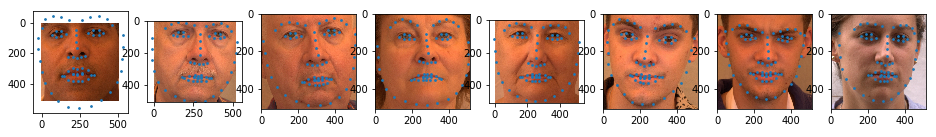

In [12]:
n_show = 8
fig, axs = plt.subplots(1, n_show, figsize=(16, 4))
for idx in range(n_show):
    sample = clf_dataset[idx]
    axs[idx].imshow(sample['image'].numpy().transpose(1,2,0)*std + mean)    
    axs[idx].scatter(sample['keypoints'][:,0], sample['keypoints'][:,1], s=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


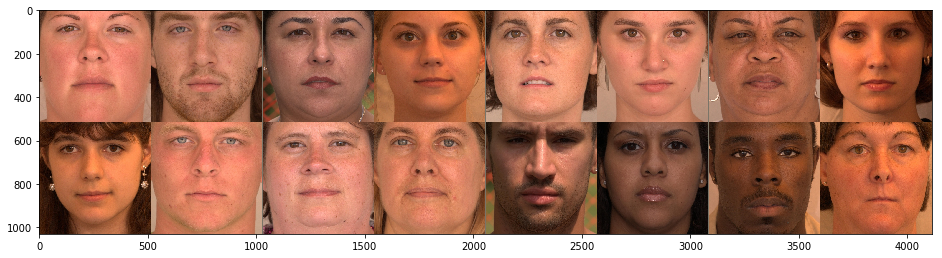

In [13]:
# clf_dataset = ClassificationDataset(ROOT, views, transform=transform_base, keypoints=False)
clf_dataset = ClassificationDataset(ROOT, views, transform=transform_kp, keypoints=True)
clf_loader = DataLoader(clf_dataset, batch_size=16, shuffle=True)

batch = next(iter(clf_loader))
grid = make_grid(batch['image'])

plt.figure(figsize=(16, 8))

plt.imshow(grid.numpy().transpose(1,2,0)*std + mean)

In [14]:
batch['label']

tensor([294, 259,  23, 116, 328, 318, 218,  96, 110, 271, 299, 420,  27, 139,
        141,  55])